# 03: Feature selection, transformations

### Import

In [13]:
import numpy as np
import pandas as pd

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize_scalar

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression, RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data load

In [14]:
df = pd.read_csv('data.csv')

### Observe target variable

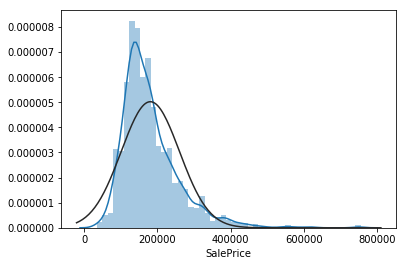

In [15]:
# Distribution of the target varaible
sns.distplot(df.SalePrice, fit=norm)

In [16]:
# Observe skewness and kurtosis as measures of asymetry and long tails
print(df.SalePrice.skew())
print(df.SalePrice.kurtosis())

# Check log transform
# центрованный
print(np.log1p(df.SalePrice).skew())

print(np.log1p(df.SalePrice).kurtosis())

1.88287575977
6.53628186006
0.121346619897
0.809519155708


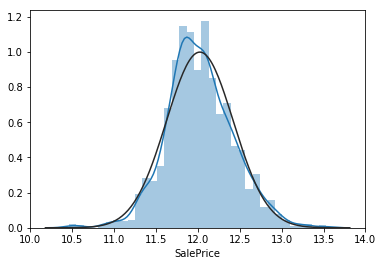

In [17]:
# Try to transform to obtain normal distribution
sns.distplot(np.log1p(df.SalePrice), fit=norm)

In [18]:
# Log transform of SalePrices
df.SalePrice = np.log1p(df.SalePrice)

In [19]:
df.MiscVal.value_counts()

0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64

### Simple clean & transform

In [20]:
# Remove Miscellaneous feature value since we don't want to create several value variables for each feature (try it at home)
df.drop(['MiscVal'], axis=1, inplace = True, errors = 'ignore')

In [21]:
# show features with largest number of missing values
display(df.isnull().sum().nlargest(5))
# find features with more than half missings
half_miss_columns = df.columns[df.isnull().sum() > len(df)/2]
# drop
df.drop(half_miss_columns, axis = 1, inplace = True)
# see result
display(df.isnull().sum().nlargest(5))

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
dtype: int64

FireplaceQu     690
LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
dtype: int64

In [22]:
# Fireplaces are connected with fireplace quality - i.e data are cleaned
df[df.Fireplaces != 0].FireplaceQu.isnull().sum()

0

In [23]:
# Fill all NaN with 0
df.fillna(0, inplace = True)

In [24]:
# This point is not necessary for later get_dummies
# See unique values for object type
display(df.select_dtypes(include=['object']).nunique().nlargest(5))
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

Neighborhood    25
Exterior2nd     16
Exterior1st     15
Condition1       9
SaleType         9
dtype: int64

In [25]:
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,12.109016


In [26]:
# Convert all Area and Square feet to log values
for column in df.filter(regex='Area|SF', axis=1).columns:
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
#     df.loc[df[column] > 0, column] = np.log(df.loc[df[column] > 0, column])
    df['Sqrt' + column] = np.sqrt(df[column])
    df['Log' + column] = np.log1p(df[column])

In [27]:
df[df.filter(regex='Area', axis=1).columns].head()

,LotArea,MasVnrArea,GrLivArea,GarageArea,PoolArea,HasLotArea,SqrtLotArea,LogLotArea,HasMasVnrArea,SqrtMasVnrArea,LogMasVnrArea,HasGrLivArea,SqrtGrLivArea,LogGrLivArea,HasGarageArea,SqrtGarageArea,LogGarageArea,HasPoolArea,SqrtPoolArea,LogPoolArea
0,8450,196.0,1710,548,0,1,91.923882,9.042040,1,14.000000,5.283204,1,41.352146,7.444833,1,23.409400,6.308098,0,0.0,0.0
1,9600,0.0,1262,460,0,1,97.979590,9.169623,0,0.000000,0.000000,1,35.524639,7.141245,1,21.447611,6.133398,0,0.0,0.0
2,11250,162.0,1786,608,0,1,106.066017,9.328212,1,12.727922,5.093750,1,42.261093,7.488294,1,24.657656,6.411818,0,0.0,0.0
3,9550,0.0,1717,642,0,1,97.724101,9.164401,0,0.000000,0.000000,1,41.436699,7.448916,1,25.337719,6.466145,0,0.0,0.0
4,14260,350.0,2198,836,0,1,119.415242,9.565284,1,18.708287,5.860786,1,46.882833,7.695758,1,28.913665,6.729824,0,0.0,0.0


In [28]:
df.nunique()

Id                  1460
MSSubClass            15
MSZoning               5
LotFrontage          111
LotArea             1073
Street                 2
LotShape               4
LandContour            4
Utilities              2
LotConfig              5
LandSlope              3
Neighborhood          25
Condition1             9
Condition2             8
BldgType               5
HouseStyle             8
OverallQual           10
OverallCond            9
YearBuilt            112
YearRemodAdd          61
RoofStyle              6
RoofMatl               8
Exterior1st           15
Exterior2nd           16
MasVnrType             5
MasVnrArea           327
ExterQual              4
ExterCond              5
Foundation             6
BsmtQual               5
                    ... 
HasBsmtUnfSF           2
SqrtBsmtUnfSF        780
LogBsmtUnfSF         780
HasTotalBsmtSF         2
SqrtTotalBsmtSF      721
LogTotalBsmtSF       721
Has1stFlrSF            1
Sqrt1stFlrSF         753
Log1stFlrSF          753


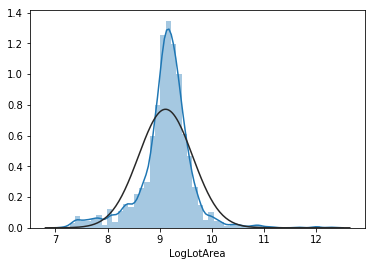

In [29]:
sns.distplot(df[df.LotArea>0].LogLotArea, fit = norm)

In [30]:
# Convert categorical variables to indicators and create new data
# This is usefull for regression (resonable model) - in the case of classification this is usually not necessary 
df = pd.get_dummies(df)
# see how many of each type we have

In [31]:
# Remove constant features
display(df.columns[df.min() == df.max()])
df = df[df.columns[df.min() != df.max()]]

Index(['HasLotArea', 'Has1stFlrSF', 'HasGrLivArea'], dtype='object')

In [32]:
# collect type column names
continuous_columns = df.select_dtypes(include=['float64']).columns
discrete_columns = df.select_dtypes(include=['int64']).columns
indicator_columns = df.select_dtypes(include=['uint8']).columns

### Split train & test data to demonstrate results

In [33]:
dt, dtest = train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dtest = dtest.copy()

In [34]:
print('Train: ', len(dt), '; Test: ', len(dtest))

Train:  1095 ; Test:  365


## Normalize features

In [35]:
# Check max and min values for indicators  - should be stored in uint8
print(dt.select_dtypes(include=['uint8']).min().min())
print(dt.select_dtypes(include=['uint8']).max().max())

0
1


In [36]:
# Standardize scaling
scaler = preprocessing.StandardScaler()

# Prepare column names - ['float64', 'int64', 'uint8']
columns = dt.select_dtypes(include=['float64', 'int64']).columns
columns = columns.drop('SalePrice', errors = 'ignore')
print(list(columns))

# Prepare values for transform
scaler.fit(dt[columns])

# Transform
dt[columns] = scaler.transform(dt[columns])
dtest[columns] = scaler.transform(dtest[columns])

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'SqrtLotArea', 'LogLotArea', 'SqrtMasVnrArea', 'LogMasVnrArea', 'SqrtBsmtFinSF1', 'LogBsmtFinSF1', 'SqrtBsmtFinSF2', 'LogBsmtFinSF2', 'SqrtBsmtUnfSF', 'LogBsmtUnfSF', 'SqrtTotalBsmtSF', 'LogTotalBsmtSF', 'Sqrt1stFlrSF', 'Log1stFlrSF', 'Sqrt2ndFlrSF', 'Log2ndFlrSF', 'SqrtLowQualFinSF', 'LogLowQualFinSF', 'SqrtGrLivArea', 'LogGrLivArea', 'SqrtGarageArea', 'LogGarageArea', 'SqrtWoodDeckSF', 'LogWoodDeckSF', 'SqrtOpenPorchSF', 'LogOpenPorchSF', 'SqrtPoolArea', 'LogPoolArea']


In [37]:
dt.dtypes.value_counts()

uint8      262
float64     65
dtype: int64

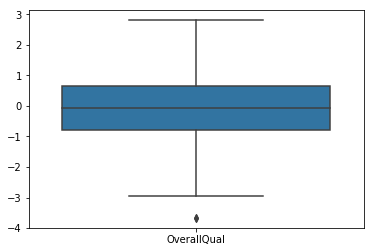

In [38]:
sns.boxplot(data=dt[['OverallQual']])

In [39]:
dt.head(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1344,1.446449,0.080938,0.747297,0.043505,0.649294,-0.517384,1.151631,1.024500,-0.569149,-0.950049,...,0,1,0,0,0,0,0,0,0,1
265,-1.125355,-0.875897,0.549301,0.134280,-0.070318,0.366447,0.332415,-0.175367,0.585630,0.311112,...,0,0,0,1,0,0,0,0,1,0
997,0.619372,-0.875897,-1.656944,0.099975,-0.070318,0.366447,-0.028040,-0.703308,2.570750,-0.950049,...,0,0,0,1,0,0,0,0,1,0


## Feature selection

### Find irelevant features

In [40]:
# Drop Id
dt.drop(['Id'], axis = 1, errors = 'ignore', inplace = True)
dtest.drop(['Id'], axis = 1, errors = 'ignore', inplace = True)

In [41]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 1344 to 623
Columns: 326 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(64), uint8(262)
memory usage: 836.2 KB


In [42]:
# Find features with low variance
columns_to_remove = dt.columns[dt.var() < 0.02]
dt[columns_to_remove].var().nlargest(5)
print(len(columns_to_remove))

113


In [43]:
# Perform t-test with indicator variables - calculate p-values
ttest_pvals = df\
    .drop(columns_to_remove, axis = 1, errors = 'ignore')\
    .select_dtypes(include = ['uint8']).columns\
    .to_series()\
    .apply(lambda x: ttest_ind(df.SalePrice[df[x] == 0], df.SalePrice[df[x] == 1], equal_var = False).pvalue)

# show largest and smallest
display(ttest_pvals.nlargest(5))
display(ttest_pvals.nsmallest(4))

LotConfig_Corner       0.877744
LotConfig_FR2          0.823166
LandContour_Lvl        0.738566
FireplaceQu_Fa         0.657915
Exterior1st_Plywood    0.513045
dtype: float64

ExterQual_TA        1.235851e-120
ExterQual_Gd        1.125116e-108
KitchenQual_TA      1.477147e-108
Foundation_PConc    1.461449e-104
dtype: float64

In [44]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.boxplot(x='HouseStyle_SLvl', y='SalePrice', data=dt,ax=axs[0])
sns.boxplot(x='ExterQual_TA', y='SalePrice', data=dt,ax=axs[1])list(set(columns_to_remove).union(set(ttest_pvals[ttest_pvals > 0.5].index)))

SyntaxError: invalid syntax (<ipython-input-44-8367aae75ab6>, line 3)

In [ ]:
# Remove all largest than 50%
columns_to_remove = list(set(columns_to_remove).union(set(ttest_pvals[ttest_pvals > 0.5].index)))
print(len(columns_to_remove))

### Correlation approach

In [48]:
# Correlation matrix Pearson Spearman
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

In [49]:
# Pearson top 10
corrP_cols = corrP.SalePrice.abs().nlargest(10).index
display(corrP.SalePrice.loc[corrP_cols])
# Spearman top 10
corrS_cols = corrS.SalePrice.abs().nlargest(10).index
display(corrS.SalePrice.loc[corrS_cols])

SalePrice         1.000000
OverallQual       0.820701
LogGrLivArea      0.731110
SqrtGrLivArea     0.720603
GrLivArea         0.694166
GarageCars        0.689327
GarageArea        0.653478
SqrtGarageArea    0.625460
Log1stFlrSF       0.617362
Sqrt1stFlrSF      0.616300
Name: SalePrice, dtype: float64

SalePrice         1.000000
OverallQual       0.810410
GrLivArea         0.735184
SqrtGrLivArea     0.735184
LogGrLivArea      0.735184
GarageCars        0.694128
GarageArea        0.648908
SqrtGarageArea    0.648908
LogGarageArea     0.648908
YearBuilt         0.644751
Name: SalePrice, dtype: float64

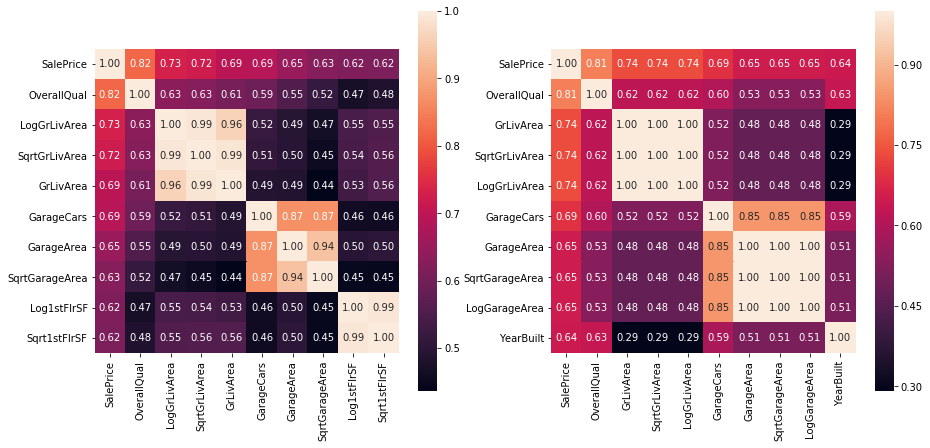

In [50]:
# Plot those correlations
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.heatmap(corrP.abs().loc[corrP_cols,corrP_cols],ax=axs[0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrP_cols.values, xticklabels=corrP_cols.values)
sns.heatmap(corrS.abs().loc[corrS_cols,corrS_cols],ax=axs[1], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrS_cols.values, xticklabels=corrS_cols.values)

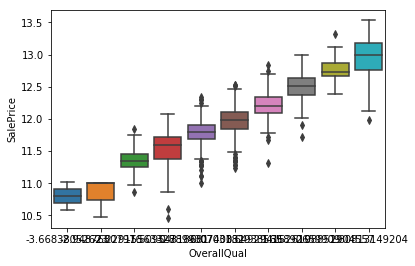

In [51]:
# OverallQual is actually orderd categorical variable stored as number
sns.boxplot(x='OverallQual', y='SalePrice', data=dt)

### Subset selection

In [52]:
# Use scikit learn to select best features
# prepare data
X = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

# calculate F values for correlation coefficient (calculated from rho using an increasing function)
# calculate p-values of the correspondong F-test (inversely proportional to rho)
Fscores, pvals = f_regression(X,y)
print(max(pvals))

0.996392876777


In [53]:
display(pd.Series(pvals, index=X.columns).nsmallest(5))
display(corrP.SalePrice.abs().nlargest(5))

OverallQual      5.878185e-268
LogGrLivArea     1.060521e-183
SqrtGrLivArea    4.835709e-176
GrLivArea        3.041475e-158
GarageCars       3.411450e-155
dtype: float64

SalePrice        1.000000
OverallQual      0.820701
LogGrLivArea     0.731110
SqrtGrLivArea    0.720603
GrLivArea        0.694166
Name: SalePrice, dtype: float64

In [54]:
# We can also use Mutual Information (information gain) - but for linear regression - correlation is usually better
mi = mutual_info_regression(X,y)
display(pd.Series(mi, index=X.columns).nlargest(5))

OverallQual        0.544074
SqrtGrLivArea      0.485801
LogGrLivArea       0.483447
GrLivArea          0.479379
SqrtTotalBsmtSF    0.382398
dtype: float64

In [55]:
# Stupid selection of n performing highest correlations
n = 100
columns_to_leave = corrP.SalePrice.abs().nlargest(n).index

In [56]:
# Select by linear regression
X = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['SalePrice'], axis = 1, errors = 'ignore')
# X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

In [57]:
used_columns = X.columns

def scorer(Y, yp):
    return np.sqrt(mean_squared_error(Y, yp))

clfM = LinearRegression()

selector = RFECV(clfM, step=1, cv=5, scoring=make_scorer(scorer))
selector = selector.fit(X, y)

In [58]:
selector

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring=make_scorer(scorer), step=1, verbose=0)

In [59]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageCond_Fa,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
1344,0.080938,0.747297,0.043505,0.649294,-0.517384,1.151631,1.024500,-0.569149,-0.950049,-0.291925,...,0,1,0,1,0,1,0,0,0,1
265,-0.875897,0.549301,0.134280,-0.070318,0.366447,0.332415,-0.175367,0.585630,0.311112,1.123096,...,0,1,0,1,0,0,1,0,1,0
997,-0.875897,-1.656944,0.099975,-0.070318,0.366447,-0.028040,-0.703308,2.570750,-0.950049,-0.291925,...,0,1,0,1,0,0,1,0,1,0
824,-0.875897,0.634157,0.053898,1.368907,-0.517384,1.151631,1.024500,-0.569149,-0.950049,-0.291925,...,0,1,0,1,0,1,0,0,0,1
985,3.190652,0.266449,0.022995,-0.789931,-0.517384,-0.683414,-1.663202,-0.569149,1.280576,-0.291925,...,0,1,0,1,0,0,0,0,1,0
1158,-0.875897,0.945294,0.119749,1.368907,-0.517384,1.184400,1.120489,0.453656,-0.950049,-0.291925,...,0,1,0,1,0,0,0,0,0,1
1124,0.559355,-1.656944,-0.138414,0.649294,-0.517384,0.692870,0.352575,0.365672,-0.950049,-0.291925,...,0,1,0,1,0,0,1,0,1,0
378,-0.875897,0.832153,0.070268,2.088519,-3.168877,1.282706,1.216479,1.355483,2.149234,-0.291925,...,0,1,0,1,0,1,0,0,0,1
685,2.473025,-1.656944,-0.512092,0.649294,-0.517384,0.430721,-0.031383,-0.569149,0.825872,0.837609,...,0,1,0,1,0,0,1,0,1,0
563,-0.158271,0.209879,1.025479,-0.070318,1.250278,-1.732011,-1.663202,-0.569149,-0.950049,-0.291925,...,0,1,1,0,0,0,1,0,1,0


In [46]:
y.head(4)

1344    11.956559
265     12.075400
997     12.128117
824     12.357080
Name: SalePrice, dtype: float64

In [47]:
# transform result to dataframe
result = pd.DataFrame({'Chosen': selector.support_, 'Ranking': selector.ranking_}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result[result.Chosen == False].head(5))
display(result.Chosen.sum())

,Chosen,Ranking
MSSubClass,False,143
LotFrontage,False,145
LotArea,False,36
OverallQual,False,18
OverallCond,False,40


55

In [48]:
result

,Chosen,Ranking
MSSubClass,False,143
LotFrontage,False,145
LotArea,False,36
OverallQual,False,18
OverallCond,False,40
YearBuilt,False,38
YearRemodAdd,False,88
MasVnrArea,False,114
BsmtFinSF1,True,1
BsmtFinSF2,True,1


## Estimation - Linear Regression

In [60]:
display(result[result.Chosen == True]))

SyntaxError: invalid syntax (<ipython-input-60-8d60feb1e8ce>, line 1)

Root mean squared logarithmic error: 0.137953483984


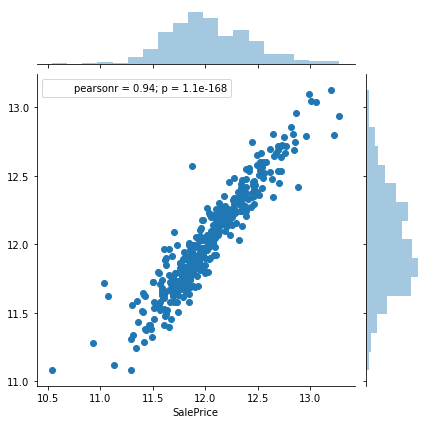

In [61]:
# Data prepare
X = dt[columns_to_leave].drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice
Xtest = dtest[columns_to_leave].drop(['SalePrice'], axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

# Linear Regression
clf1 = LinearRegression()
clf1.fit(X, y) 

# Print RMSLE
print('Root mean squared logarithmic error:', np.sqrt(mean_squared_error(clf1.predict(Xtest), ytest)))
# Joint Plot
sns.jointplot(ytest, clf1.predict(Xtest))

Root mean squared logarithmic error: 211139357.294


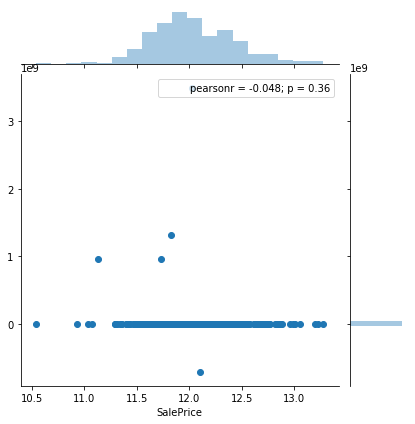

In [62]:
# Data prepare with all features
X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
# X = X.drop(columns_to_remove, axis = 1, errors = 'ignore')
y = dt.SalePrice

Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
# Xtest = Xtest.drop(columns_to_remove, axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

# Linear Regression
clf1 = LinearRegression()
clf1.fit(X, y) 

# Print RMSLE
print('Root mean squared logarithmic error:', np.sqrt(mean_squared_error(clf1.predict(Xtest), ytest)))
# Joint Plot
sns.jointplot(ytest, clf1.predict(Xtest))

In [151]:
columns_to_leave

Index(['TotalBsmtSF', 'PoolArea', 'HasBsmtFinSF1', 'HasBsmtFinSF2',
       'HasTotalBsmtSF', 'SqrtTotalBsmtSF', 'LogTotalBsmtSF', 'Has2ndFlrSF',
       'Log2ndFlrSF', 'SqrtPoolArea', 'LogPoolArea', 'BsmtQual_0',
       'BsmtCond_0', 'BsmtFinType1_0', 'BsmtFinType1_Unf', 'BsmtFinType2_Unf'],
      dtype='object')

### Estimation  - Ridge Regression

     fun: 0.12606161491482068
 message: 'Solution found.'
    nfev: 20
  status: 0
 success: True
       x: 4.9628034973032005
Root mean squared logarithmic error: 0.116615894397


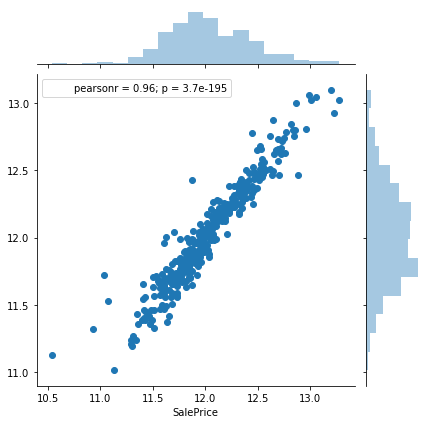

In [40]:
# Data prepare with all features
X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
# X = X.drop(columns_to_remove, axis = 1, errors = 'ignore')
y = dt.SalePrice

Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
# Xtest = Xtest.drop(columns_to_remove, axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

# Determine alpha using cross validation
def scorer(Y, yp):
    return np.sqrt(mean_squared_error(Y, yp))

def fun(alpha):
    clf = Ridge(alpha=alpha)
    return np.mean(cross_val_score(clf, X, y, cv=5, scoring=make_scorer(scorer)))

# minimize
opt_alpha = minimize_scalar(fun, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
print(opt_alpha)

# Ridge regression
clf2 = Ridge(alpha=opt_alpha.x)
clf2.fit(X, y) 

# Print RMSLE
print('Root mean squared logarithmic error:', np.sqrt(mean_squared_error(clf2.predict(Xtest), ytest)))

# Joint Plot
sns.jointplot(ytest, clf2.predict(Xtest))

### Estimation - Kernel Regression

     fun: 0.13765674274845302
 message: 'Solution found.'
    nfev: 20
  status: 0
 success: True
       x: 0.48500603091983824
Root mean squared logarithmic error: 0.139271886068


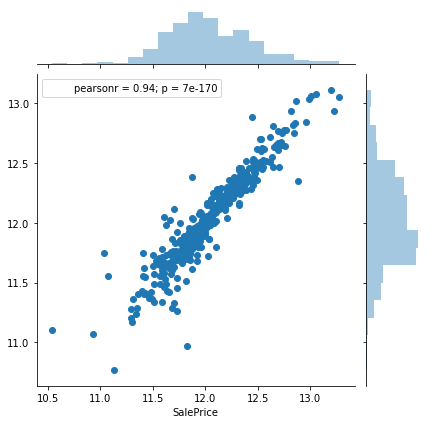

In [41]:
# Data prepare with all features
X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
# X = X.drop(columns_to_remove, axis = 1, errors = 'ignore')
y = dt.SalePrice

Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
# Xtest = Xtest.drop(columns_to_remove, axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

# Determine alpha using cross validation
def scorer(Y, yp):
    return np.sqrt(mean_squared_error(Y, yp))

def fun(alpha):
    clf = KernelRidge(alpha=alpha)
    return np.mean(cross_val_score(clf, X, y, cv=5, scoring=make_scorer(scorer)))

# minimize
opt_alpha = minimize_scalar(fun, options = {'maxiter': 40}, method='bounded', bounds=(0.001, 100))
print(opt_alpha)

# Ridge regression
clf3 = KernelRidge(alpha=opt_alpha.x)
clf3.fit(X, y) 

# Print RMSLE
print('Root mean squared logarithmic error:', np.sqrt(mean_squared_error(clf3.predict(Xtest), ytest)))

# Joint Plot
sns.jointplot(ytest, clf3.predict(Xtest))





## Homework task 3:
* Load homework_data.csv.
* Analyze the distribution of 'price' and try to transform it into normal distibution.
* Perform proper feature transformations.
* Remove all irelevant features.
* Select a proper subset of features.
* Try to construct linear regression model to predict prices. Evaluate its root mean squared logarithmic error.

In [42]:
dh = pd.read_csv('homework_data.csv')